In [22]:
from DataSimulations import simulate
from Data import DataSet
from Models.LSTM_VAR import LSTM_VAR
import logging
import Train
from Train import set_seed
import keras
from HelpComputation import *
from HelpLatex import *
from HelpPlot import *
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Experiment 4: More Time Series

In [2]:
n, p = 1000, 4
test = "Experiment4MoreTimeSeries"
time_series_options = [3, 6, 12, 24]

# Run Experiment

In [3]:
var_results = []
for seed in range(0, 10):
    
    models_results = {'metrics':[], 'gradients':[]}
    for m in time_series_options:
        print('Simulation',seed)
        set_seed(seed)
        # Simulate Data
        simulation = simulate(n, m, p, seed=seed)
        param = simulation['parameters']
        data = simulation['v']
        dataset = DataSet(data.values).preprocessing(1, p, 0.8, 0.1, scale=False) # Include p lags in X, forecast horizon = 1
    
        # VAR
        var_coefs = VAR.get_var_coefficients(dataset.train,p)
        var_eval = Evaluation.matrix_rmse(var_coefs, param['companion_matrix'][:m])
        var_eval['test_rmse'] = Evaluation.root_mean_squared_error(VAR.predict(var_coefs, dataset.test), dataset.test[param['p']:])
        var_eval['simulation'] = param['seed']
        var_eval['model'] = f'VAR: Data m={m}'
        var_results.append(var_eval)
        
        # LSTM-VAR
        models = {f'LSTM-VAR: Data m={m}': LSTM_VAR(m, p=param['p'], units=64, scaler=dataset.scaler)
              }
        for model_name in models:
            print(model_name, end=' ')
            trained_model, model_eval = Train.train_model(model=models[model_name],dataset=dataset, param=param, epochs=200, verbose=2)
            if seed==0:
                # replace : with "" to avoid problems with saving
                trained_model.save(test+'/models/'+model_name.replace(':',''), save_format="tf")
            t1 = model_eval['metrics']
            t1['model'] = model_name
            t1['simulation'] = param['seed']
        
            t2 = model_eval['gradients']
            t2['model'] = model_name
            t2['simulation'] = param['seed']
        
            models_results['metrics'].append(t1)
            models_results['gradients'].append(t2)
    save(pd.concat(models_results['metrics']), f'metrics_sim{seed}', test+'/results')
    save(pd.concat(models_results['gradients']), f'gradients_sim{seed}', test+'/results')

save(pd.DataFrame(var_results), 'var_results', test+'/results')

Simulation 0
LSTM-VAR: Data m=3 Epoch 1/200
25/25 - 3s - loss: 1.8065 - val_loss: 1.4972 - 3s/epoch - 107ms/step
Epoch 2/200
25/25 - 0s - loss: 1.4245 - val_loss: 1.2165 - 185ms/epoch - 7ms/step
Epoch 3/200
25/25 - 0s - loss: 1.2030 - val_loss: 1.0786 - 172ms/epoch - 7ms/step
Epoch 4/200
25/25 - 0s - loss: 1.1001 - val_loss: 1.0243 - 200ms/epoch - 8ms/step
Epoch 5/200
25/25 - 0s - loss: 1.0490 - val_loss: 0.9986 - 201ms/epoch - 8ms/step
Epoch 6/200
25/25 - 0s - loss: 1.0177 - val_loss: 0.9809 - 171ms/epoch - 7ms/step
Epoch 7/200
25/25 - 0s - loss: 0.9967 - val_loss: 0.9724 - 173ms/epoch - 7ms/step
Epoch 8/200
25/25 - 0s - loss: 0.9819 - val_loss: 0.9655 - 193ms/epoch - 8ms/step
Epoch 9/200
25/25 - 0s - loss: 0.9707 - val_loss: 0.9590 - 203ms/epoch - 8ms/step
Epoch 10/200
25/25 - 0s - loss: 0.9634 - val_loss: 0.9572 - 191ms/epoch - 8ms/step
Epoch 11/200
25/25 - 0s - loss: 0.9580 - val_loss: 0.9565 - 187ms/epoch - 7ms/step
Epoch 12/200
25/25 - 0s - loss: 0.9537 - val_loss: 0.9556 - 192ms

# Plotting

In [3]:
# TODO Remember to change based on experiment
vars = ['VAR: Data m='+str(m) for m in time_series_options]
lstm_vars = [f'LSTM-VAR: Data m={m}' for m in time_series_options]
counterparts = vars # can be list of lists if true model is known

In [4]:
order = vars + lstm_vars
palette = sns.color_palette("Set1", n_colors=len(order))
metrics = rename_columns(pd.concat([pd.read_csv(test+'/results/'+file) for file in os.listdir(test+'/results') if 'metrics_sim' in file]).reset_index(drop=True))
gradients = rename_variables(rename_columns(pd.concat([pd.read_csv(test+'/results/'+file) for file in os.listdir(test+'/results') if 'gradients_sim' in file]).reset_index(drop=True)))
var_results = rename_columns(pd.read_csv(test+'/results/var_results.csv'))

## Performance over epochs

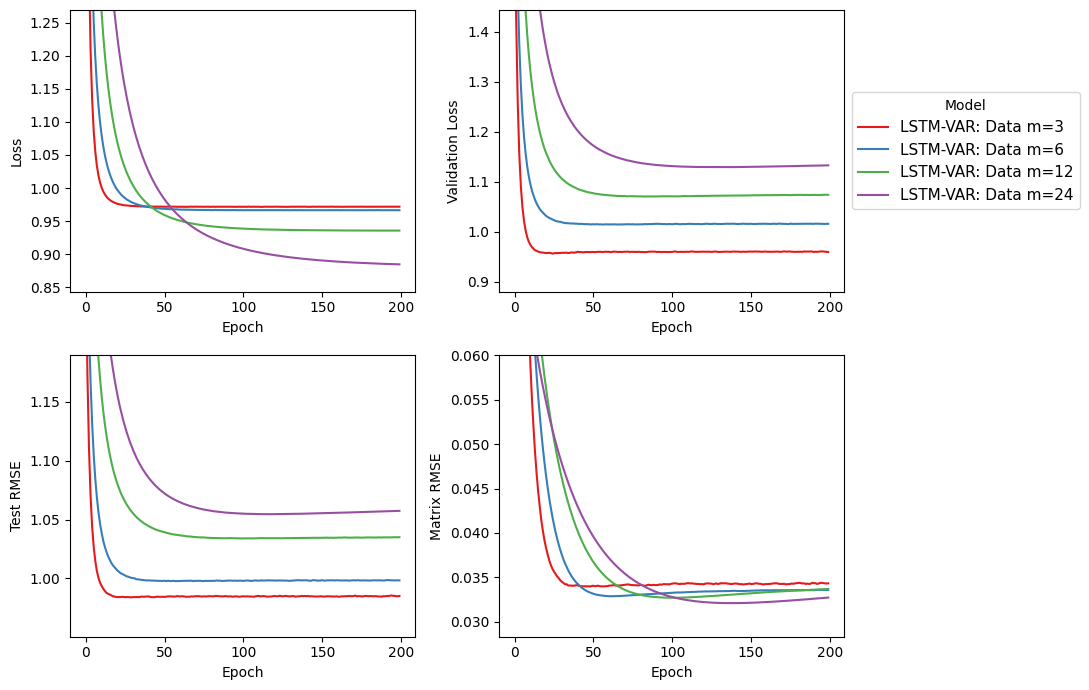

In [8]:
# 1. 2x2 metrics over epochs
fig = plot_performances_over_epochs(metrics, thresholds=[0.1, 0.1, 0.1, 0.1], palette=palette[:len(lstm_vars)])
fig.savefig(test+'/epochs.png')

# Evolution of the loss, validation loss, test RMSE and matrix RMSE over Epochs

In [9]:
var_results.groupby('Model').mean()[['Matrix RMSE', 'Test RMSE', 'Same Sign %']].reindex(vars)

,Matrix RMSE,Test RMSE,Same Sign %
Model,,,
VAR: Data m=3,0.034275,0.982488,0.947222
VAR: Data m=6,0.033562,0.997054,0.922222
VAR: Data m=12,0.034167,1.035187,0.908160
VAR: Data m=24,0.035637,1.063318,0.862500


In [10]:
metrics.groupby(['Model', 'Epoch']).mean()[['Validation Loss', 'Matrix RMSE', 'Test RMSE',  'Same Sign %']].reset_index().groupby(['Model']).min().reindex(lstm_vars)

,Epoch,Validation Loss,Matrix RMSE,Test RMSE,Same Sign %
Model,,,,,
LSTM-VAR: Data m=3,0,0.956638,0.033948,0.983991,0.733333
LSTM-VAR: Data m=6,0,1.014677,0.032859,0.997690,0.591667
LSTM-VAR: Data m=12,0,1.070687,0.032687,1.033985,0.547917
LSTM-VAR: Data m=24,0,1.129314,0.032084,1.054575,0.513542


## Gradient analysis
Kernel = what handles the X
Reccurent Kernel = what handles the cell state

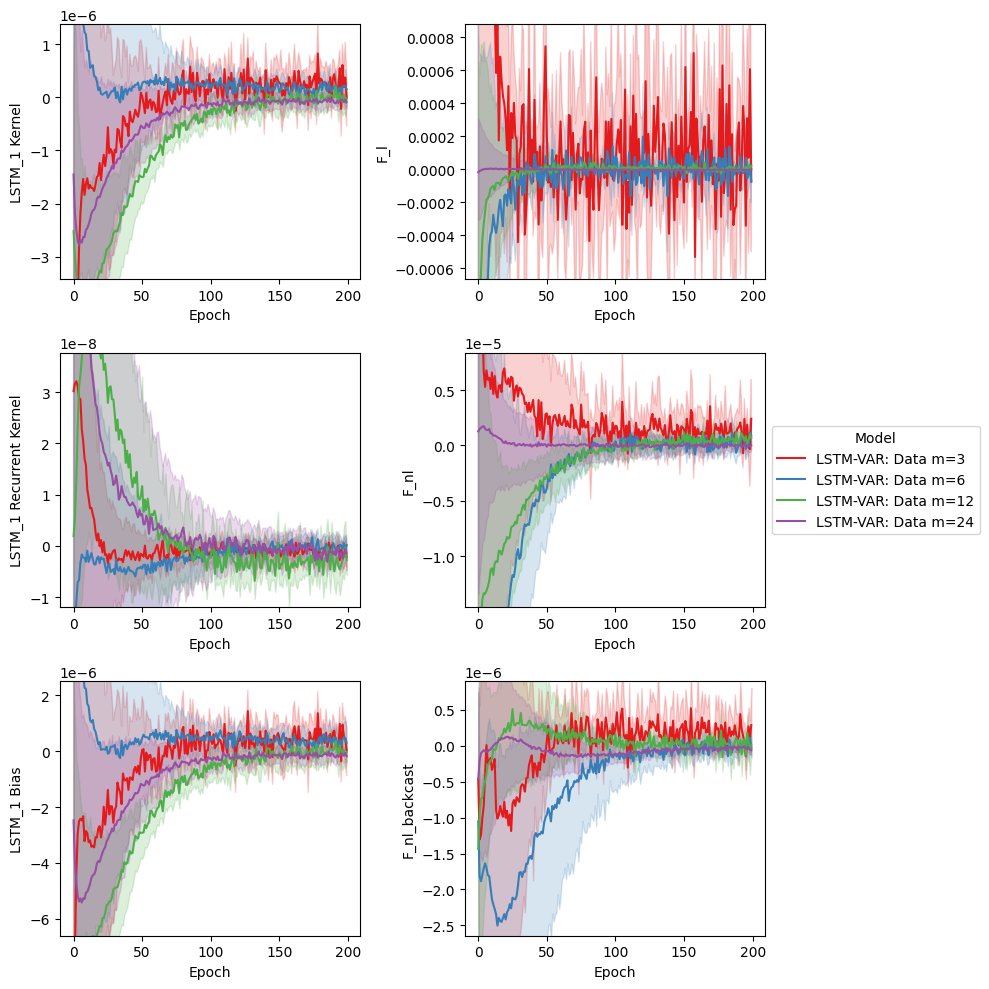

In [11]:
# 2. Gradient over epochs
fig = plot_gradients_over_epochs(gradients, palette[:len(lstm_vars)])
fig.savefig(test+'/gradients.png')

# Evolution of Gradients with Standard Deviation

## Convergence analysis
Table with mean (std), % difference (std) for matrix and val loss.

In [12]:
# 3. Convergence table
converge = compute_convergence(metrics)
table = converge_to_latex_table(converge, lstm_vars)
print(table.style.to_latex())
# Convergence Metrics and Relative Change Across LSTM-VAR Models

Means: Validation Convergence  mean    48.0000
                        std      8.6825
Matrix Convergence      mean    79.6500
                        std     18.0175
Ratio                   mean     1.6825
                        std      0.3025
dtype: float64
\begin{tabular}{llll}
 & Validation Convergence & Matrix Convergence & Ratio \\
Model &  &  &  \\
LSTM-VAR: Data m=3 & 26.6 (6.59) & 46.3 (19.04) & 1.76 (0.69) \\
LSTM-VAR: Data m=6 & 37.5 (6.82) & 62.5 (18.8) & 1.66 (0.31) \\
LSTM-VAR: Data m=12 & 53.9 (10.94) & 92.1 (15.62) & 1.72 (0.15) \\
LSTM-VAR: Data m=24 & 74.0 (10.38) & 117.7 (18.61) & 1.59 (0.06) \\
\end{tabular}


Statistical test to see if the relative change between convergences is significantly different between models

In [14]:
# 4. Convergence differences statistical test
groups = converge.groupby('Simulation')['Ratio'].apply(lambda x: x.dropna().values).tolist()
f_statistic, p_value = stats.f_oneway(*groups)
print('Between simulations')
print(f"P-value: {p_value}", f"--- F-statistic: {f_statistic}")

groups = converge.groupby('Model')['Ratio'].apply(lambda x: x.dropna().values).tolist()
f_statistic, p_value = stats.f_oneway(*groups)
print('Between models')
print(f"P-value: {p_value}", f"--- F-statistic: {f_statistic}")
print('Ratio Q3:', converge['Ratio'].quantile(0.90))

Between simulations
P-value: 0.5270744971633297 --- F-statistic: 0.9131133795659551
Between models
P-value: 0.7713179878764261 --- F-statistic: 0.37530779438529255
Ratio Q3: 1.9755


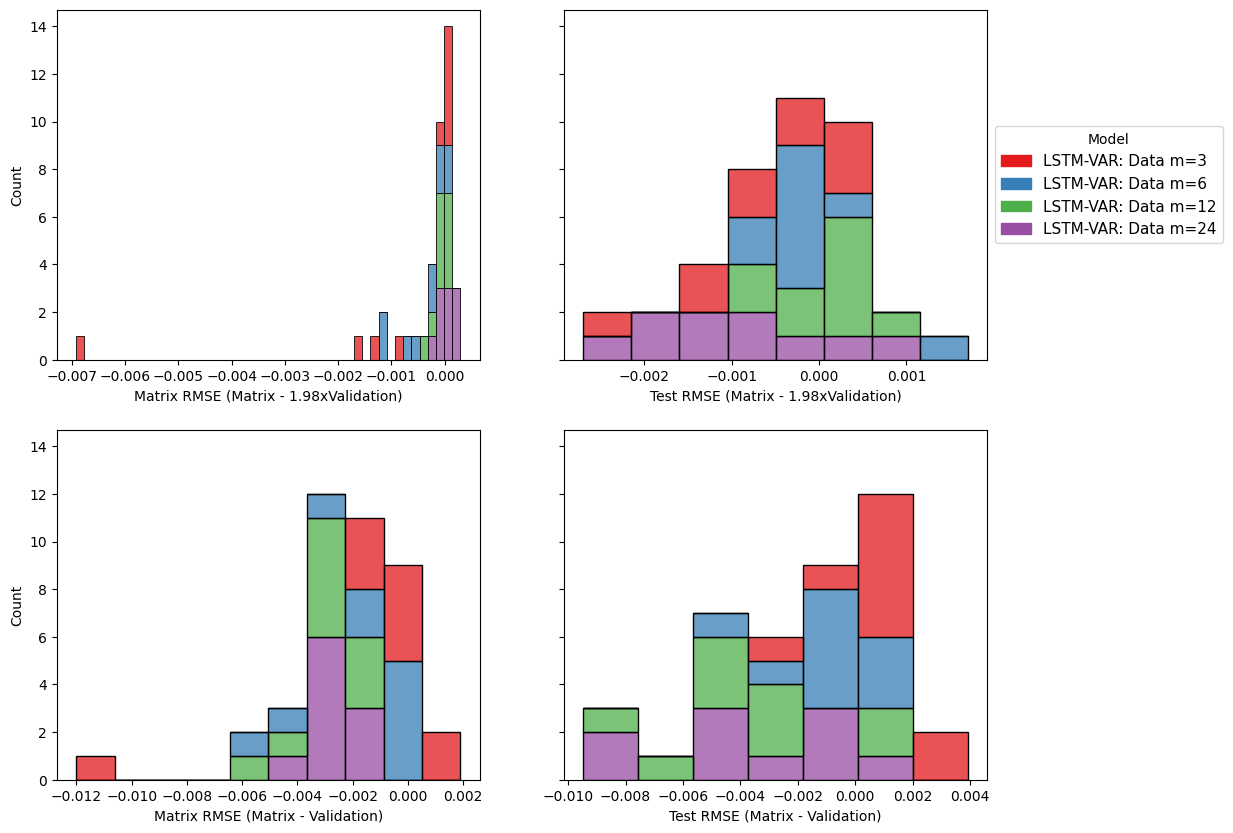

In [21]:
# 5. Convergence metric differences histogram
q3 = np.round(converge['Ratio'].quantile(0.90), 2)
est = get_converged(metrics, converge.set_index(['Model', 'Simulation'])['Validation Convergence']*q3, lstm_vars) # Using Q3 of ratio
mat = get_converged(metrics, converge.set_index(['Model', 'Simulation'])['Matrix Convergence'], lstm_vars)
val = get_converged(metrics, converge.set_index(['Model', 'Simulation'])['Validation Convergence'], lstm_vars)

# Difference between matrix and estimated convergence and between matrix and validation convergence
test_diff = mat[['Matrix RMSE', 'Test RMSE', 'Model', 'Simulation']].reset_index(drop=True)
test_diff.loc[:, f'Test RMSE (Matrix - {q3}xValidation)'] = test_diff['Test RMSE'] - est['Test RMSE']
test_diff.loc[:, f'Matrix RMSE (Matrix - {q3}xValidation)'] = test_diff['Matrix RMSE'] - est['Matrix RMSE']
test_diff.loc[:, 'Test RMSE (Matrix - Validation)'] = test_diff['Test RMSE'] - val['Test RMSE']
test_diff.loc[:, 'Matrix RMSE (Matrix - Validation)'] = test_diff['Matrix RMSE'] - val['Matrix RMSE']
# Re-order
min_diff = order_df((est.sort_values(by=['Model', 'Simulation']).set_index(['Model','Simulation'])[['Matrix RMSE', 'Test RMSE']] - metrics.groupby(['Model', 'Simulation']).min()[['Matrix RMSE', 'Test RMSE']]).reset_index(), lstm_vars)

fig = plot_convergence_differences(
    [{'df':[test_diff, test_diff], 'columns':[f'Matrix RMSE (Matrix - {q3}xValidation)', f'Test RMSE (Matrix - {q3}xValidation)'], 'hue':'Model', 'legend':True, 'palette': palette[:len(lstm_vars)]},
     {'df':[test_diff, test_diff], 'columns':['Matrix RMSE (Matrix - Validation)', 'Test RMSE (Matrix - Validation)'], 'hue':'Model', 'legend':False, 'palette': palette[:len(lstm_vars)]}])
fig.savefig(test+'/convdiff.png')

# Histograms of Differences in Convergence Metrics

In [16]:
print(test_diff.describe()[['Matrix RMSE (Matrix - Validation)', f'Matrix RMSE (Matrix - {q3}xValidation)', 'Test RMSE (Matrix - Validation)', f'Test RMSE (Matrix - {q3}xValidation)']].loc[['min','max']])

     Matrix RMSE (Matrix - Validation)  \
min                          -0.012008   
max                           0.001896   

     Matrix RMSE (Matrix - 1.9755xValidation)  \
min                                 -0.006921   
max                                  0.000297   

     Test RMSE (Matrix - Validation)  Test RMSE (Matrix - 1.9755xValidation)  
min                        -0.009468                               -0.002590  
max                         0.003917                                0.001327  


## Convergence results

Table of model, matrix sim, test mse (mean (std)), % difference
Table of statistical tests
Heatmap or joyplot plot of variable and lag eucl dist (2 parts)

In [17]:
# 6. Results table
results = pd.concat([val.drop(columns=['Loss', 'Validation Loss', 'Epoch']), var_results])
table = results_to_latex_table(results, lstm_vars, vars)
print(table[['Matrix RMSE', 'Test RMSE']].style.to_latex())

print(table[['Same Sign %']].style.to_latex())
# Performance of LSTM-VAR Models and VAR Models

\begin{tabular}{lllll}
 & \multicolumn{2}{r}{Matrix RMSE} & \multicolumn{2}{r}{Test RMSE} \\
 & Mean & Change (vs VAR) & Mean & Change (vs VAR) \\
Model &  &  &  &  \\
VAR: Data m=3 & 0.034 (0.004) & - & 0.982 (0.058) & - \\
VAR: Data m=6 & 0.034 (0.003) & - & 0.997 (0.032) & - \\
VAR: Data m=12 & 0.034 (0.001) & - & 1.035 (0.019) & - \\
VAR: Data m=24 & 0.036 (0.0) & - & 1.063 (0.016) & - \\
LSTM-VAR: Data m=3 & 0.034 (0.005) & -0.334\% & 0.983 (0.057) & -0.099\% \\
LSTM-VAR: Data m=6 & 0.034 (0.002) & -1.842\% & 0.998 (0.031) & -0.136\% \\
LSTM-VAR: Data m=12 & 0.035 (0.002) & -3.878\% & 1.037 (0.019) & -0.215\% \\
LSTM-VAR: Data m=24 & 0.035 (0.001) & 2.916\% & 1.058 (0.016) & 0.508\% \\
\end{tabular}

\begin{tabular}{lll}
 & \multicolumn{2}{r}{Same Sign %} \\
 & Mean & Change (vs VAR) \\
Model &  &  \\
VAR: Data m=3 & 0.947 (0.046) & - \\
VAR: Data m=6 & 0.922 (0.038) & - \\
VAR: Data m=12 & 0.908 (0.012) & - \\
VAR: Data m=24 & 0.862 (0.015) & - \\
LSTM-VAR: Data m=3 & 0.933 (0.04

In [23]:
# 7. Results p-values table
table = compute_p_values(results, lstm_vars, counterparts)

print(table[['Matrix RMSE', 'Test RMSE', 'Same Sign %']].style.to_latex())
# Statistical Test Results for LSTM-VAR Models vs. VAR Model

\begin{tabular}{llll}
p-value of & Matrix RMSE & Test RMSE & Same Sign % \\
against & VAR & VAR & VAR \\
LSTM-VAR: Data m=3 & 0.948 & 0.230 & 0.096 \\
LSTM-VAR: Data m=6 & 0.472 & 0.217 & *0.035 \\
LSTM-VAR: Data m=12 & *0.046 & 0.218 & *0.003 \\
LSTM-VAR: Data m=24 & *0.028 & *0.041 & *0.000 \\
\end{tabular}


## Variable-wise and lag-wise RMSE

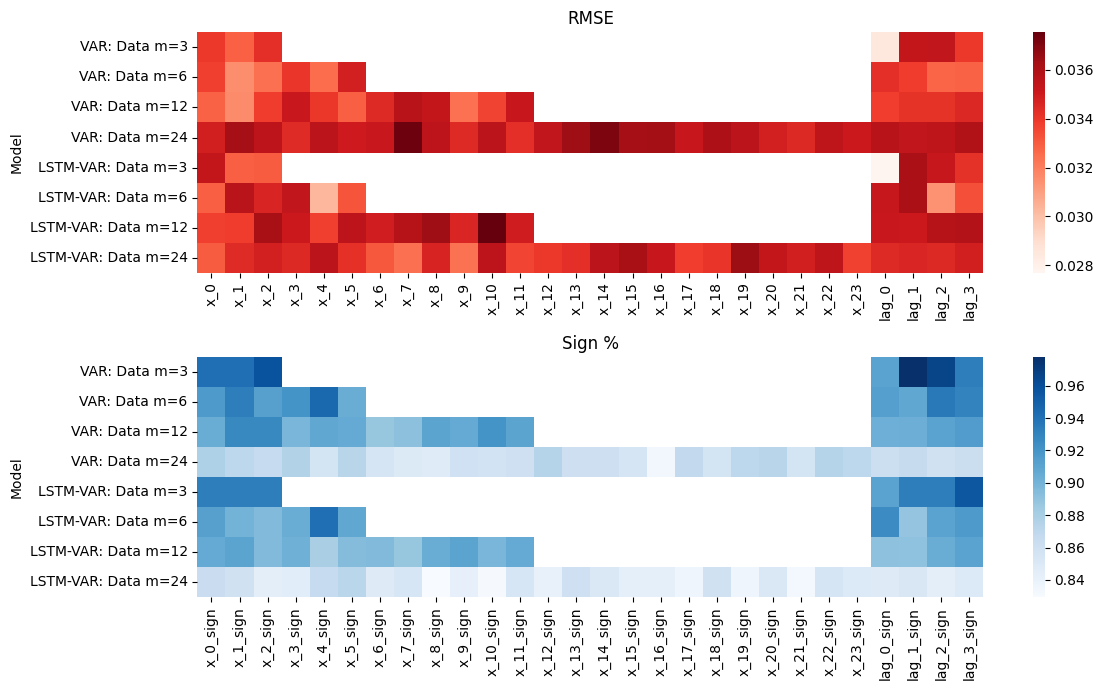

In [19]:
# 8. Variable wise and lag wise heatmap
fig = plot_heatmap(results, vars, lstm_vars)
fig.savefig(test+'/lags_n_vars.png')

## Forecast breakdown

In [20]:
# 9. Breakdown of forecasts

# Read all models in test/models
models = {file:keras.models.load_model(test+'/models/'+file) for file in os.listdir(test+'/models')}
print(models.keys())

dict_keys(['LSTM-VAR Data m=12', 'LSTM-VAR Data m=24', 'LSTM-VAR Data m=3', 'LSTM-VAR Data m=6'])


In [21]:
# TODO Pick model and what you want to plot
model = models['LSTM-VAR Data m=12']
m = 12
dgp = 'v' # v, t, s, vt, vs, ts, vts
time_series = 0 # 0 to m-1

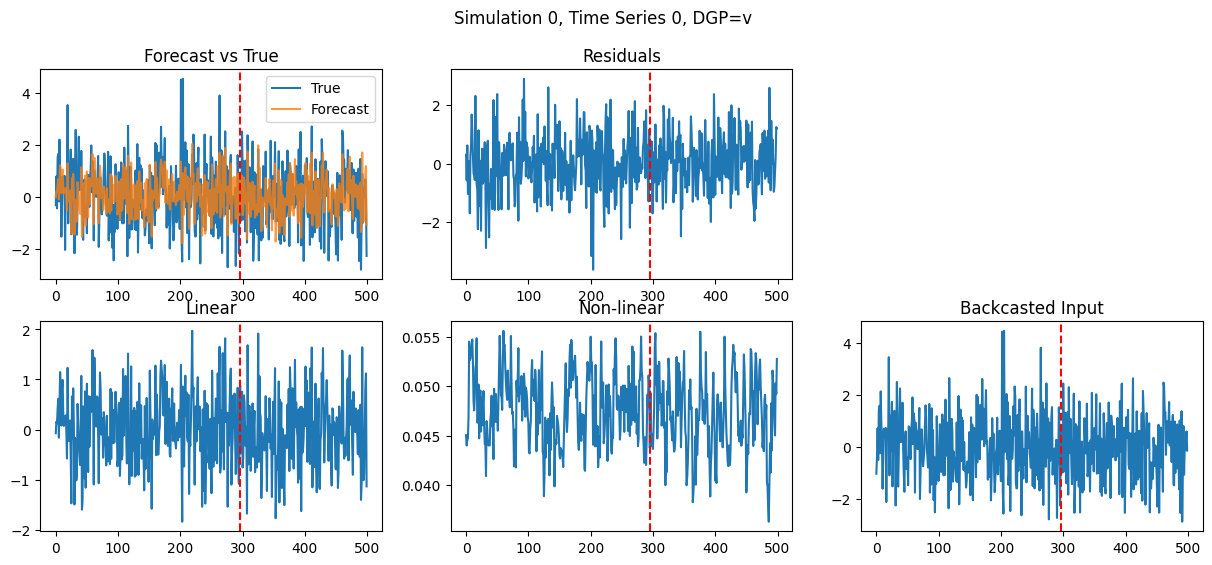

In [22]:
input_window = 4 # depends on model
simulation = simulate(n, m, p, seed=0)
dataset = DataSet(simulation[dgp].values).preprocessing(1, input_window, 0.8, 0.1, scale=False)
fig = plot_forecast_breakdown(model, dataset, time_series, dgp)